In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky,LinAlgError
from modified_minimize import *
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEFAULT_WIDTH = 20
DEFAULT_DEPTH = 4

class PINN_U(nn.Module):
    def __init__(self, width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH):
        super(PINN_U, self).__init__()
        self.width = width
        if depth < 2:
          raise ValueError(f"depth must be at least 2, got {depth}")
        self.depth = depth
        self.act = nn.Tanh()

        # layer definitions
        self.FC_dict = nn.ModuleDict()
        self.FC_dict[f"layer 1"] = nn.Linear(1, self.width)
        for i in range(2, depth):
          self.FC_dict[f"layer {i}"] = nn.Linear(self.width, self.width)
        self.FC_dict[f"layer {depth}"] = nn.Linear(self.width, 1)

    def forward(self, x):
      for key, layer in self.FC_dict.items():
        x = layer(x)
        if key != f"layer {self.depth}":
          x = self.act(x)
      return x
    
model_U = PINN_U().to(device)
print(model_U)
LAMBDA_INIT = 0.4
l = torch.tensor([LAMBDA_INIT,], dtype=torch.float64, device=device, requires_grad=True)

params = list(model_U.parameters()) 

PINN_U(
  (act): Tanh()
  (FC_dict): ModuleDict(
    (layer 1): Linear(in_features=1, out_features=20, bias=True)
    (layer 2): Linear(in_features=20, out_features=20, bias=True)
    (layer 3): Linear(in_features=20, out_features=20, bias=True)
    (layer 4): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [6]:
def compute_loss(model_U,l,y1,c):
    #interior and smoothness losses
    z1 = torch.sinh(y1)
    U = model_U(y1)-model_U(-y1)-z1**(2/7)*(z1/(1+z1))**15
    Uy = grad(U.sum(), y1, create_graph=True)[0]
    Fu = -l * U + ((1+l)*torch.sinh(y1)+U)/torch.cosh(y1) * Uy
    Fu_x = grad(Fu.sum(), y1, create_graph=True)[0]
    loss_i = torch.mean(Fu**2)
    loss_s = torch.mean(Fu_x**2)
    
    # define the loss on the boundary
    k= np.sinh(c)
    z = torch.tensor([c], dtype=torch.double, device=device, requires_grad=True).reshape(1,1) # (batch, 1)
    U = model_U(z)-model_U(-z)
    loss_b = torch.abs(U)**2
    loss =0.1*loss_i +1*loss_b +0.1*loss_s
    return [loss, loss_i, loss_b, loss_s]
def get_flat_params(model_U):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model_U.parameters()])
def set_flat_params(model_U,flat_params):
    """Set model parameters from a flat NumPy array."""
    
    idx = 0
    for p in model_U.parameters():
        numel = p.numel()
        new_values = torch.from_numpy(flat_params[idx:idx+numel]).reshape(p.shape)
        p.data.copy_(new_values)
        idx += numel
def loss_and_grad(flat_params,model_U,l,y1,c):
    """Compute loss and gradients for BFGS."""
    set_flat_params(model_U,flat_params)  # Update model parameters
    model_U.zero_grad()
    if l.grad is not None:
        l.grad.zero_()
    [loss, loss_i, loss_b, loss_s]= compute_loss(model_U,l,y1,c)  # Compute loss
  
    # Compute gradients
    loss.backward()
    grads = np.concatenate([p.grad.detach().cpu().numpy().ravel() for p in model_U.parameters()])
   
    
    return loss.item(), grads  # SciPy requires (loss, gradients)
def lbfgsrun(model_U,l,c,batchsize,Nprint_bfgs,Nchange,Nbfgs):

    torch.manual_seed(0)
    np.random.seed(0)
    y1 = ( (c*torch.rand(batchsize, 1, device=device)))# (batch, 1) resample y
    y1.requires_grad=True
    
    # Initialize parameters
    init_params = get_flat_params(model_U)
   

    cont=0
    losses = np.zeros(Nbfgs//Nprint_bfgs+100)
    initial_scale=False
    def callback(*,intermediate_result): 
        nonlocal cont,losses
        if (cont+1)%Nprint_bfgs == 0 or cont == 0:
            loss_value = intermediate_result.fun
            losses[(cont+1)//Nprint_bfgs] = loss_value
            
    
            print(loss_value,cont+1)
        cont+=1
    H0 = torch.eye(len(init_params))
    H0 = H0.numpy()
    options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
    
    while cont < Nbfgs: #Training loop
        result = minimize(loss_and_grad,init_params,args = (model_U, l,y1,c),
              method="BFGS",jac=True, options=options,
              tol=0,callback=callback) 
        init_params = result.x
    
        H0 = result.hess_inv
        H0 = (H0 + np.transpose(H0))/2
        try:
            cholesky(H0)
        except LinAlgError:
            H0 = torch.eye(len(init_params))
            H0 = H0.numpy()
    
        options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
        y1 = ( (c*torch.rand(batchsize, 1, device=device)))# (batch, 1) resample y
        y1.requires_grad=True
    return losses

In [7]:
losses = lbfgsrun(model_U, l,c=30,batchsize=10000,Nprint_bfgs=100,Nchange=1000,Nbfgs=20000)

0.16685209896913325 1
9.821080216099553e-08 100
4.486775394803235e-08 200
7.729916654974478e-10 300
2.4019312264480068e-11 400
6.2580970637913785e-12 500
1.49255854958867e-12 600
8.075228915308658e-13 700
4.2288644484110065e-13 800
1.9998552500823253e-13 900
1.1063473387933535e-13 1000
6.287254363023e-14 1100
4.175136682793696e-14 1200
2.8194558539974804e-14 1300
2.1649597903820416e-14 1400
1.6406154060677973e-14 1500
1.0989528726977379e-14 1600
8.680210005523122e-15 1700
6.398927044076083e-15 1800
3.649468002554394e-15 1900
2.809110362253443e-15 2000
2.84320978455205e-15 2100
2.5179250735961948e-15 2200
2.2578344325947807e-15 2300
2.160836735140285e-15 2400
2.013791155756094e-15 2500
1.844741831323519e-15 2600
1.7030357105325079e-15 2700
1.524864269349776e-15 2800
1.4151852141219522e-15 2900
1.2149813417842953e-15 3000
1.5106378430460294e-15 3100
1.4871458612651914e-15 3200
1.4511248525535409e-15 3300
1.3876786728431454e-15 3400
1.2888284247649553e-15 3500
1.187058958233656e-15 3600
1

tensor([0.4000], device='cuda:0', requires_grad=True)


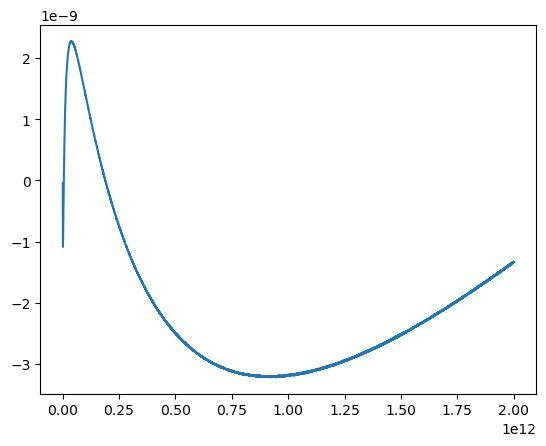

In [8]:
y = torch.linspace(2000000000000,0,10001, requires_grad=True).to(device).reshape(10001,1)
z =  torch.arcsinh(y)    
U = model_U(z)-model_U(-z)-y**(2/7)*(y/(1+y))**15
print(l)


Uy = grad(U.sum(), y, create_graph=True)[0]
#interior and smoothness losses
Fu = -l * U + ((1+l)*y + U) * Uy


fig = plt.figure()
plt.plot(y.detach().cpu().numpy(), Fu.detach().cpu().numpy())
plt.show()


In [9]:
torch.save(model_U.state_dict(), f"model_U_10000batch_20000its_exact04.pth")

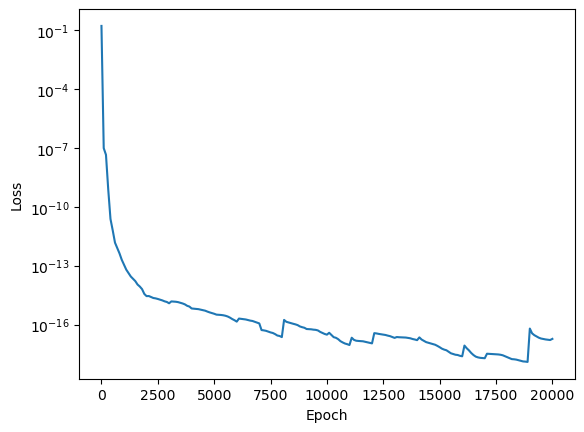

In [10]:
fig = plt.figure()
plt.xlabel('Epoch') 
plt.ylabel('Loss')
x=[i*100 for i in range(201)]
plt.semilogy(x,losses[:201])
plt.show()